In [1]:
import pandas as pd
import networkx as nx

In [3]:
# Load bus stops data
bus_stops_df = pd.read_csv("../data/london_transport/Bus-Stops.csv")

# Create a graph
G = nx.Graph()

# Add nodes with attributes
for _, row in bus_stops_df.iterrows():
    node_id = row['Stop_Code_LBSL']
    attrs = row.drop('Stop_Code_LBSL').to_dict()
    G.add_node(node_id, **attrs)

# Show number of nodes and example node attributes
print(f"Total bus stops: {G.number_of_nodes()}")
print("Example node:", list(G.nodes(data=True))[0])

Total bus stops: 19600
Example node: ('1000', {'Bus_Stop_Code': '91532', 'Naptan_Atco': '490000266G', 'Stop_Name': 'WESTMINSTER STN <> / PARLIAMENT SQUARE', 'Location_Easting': 530171, 'Location_Northing': 179738, 'Heading': 177.0, 'Stop_Area': '0K08', 'Virtual_Bus_Stop': 0, 'Latitude': 51.501597, 'Longitude': -0.12598822})


In [6]:
# Load bus routes data
bus_routes_df = pd.read_csv("../data/london_transport/Bus-Routes.csv")

# Create a directed graph for routes
DG = nx.DiGraph()

# Add all nodes from G to DG (preserving attributes)
DG.add_nodes_from(G.nodes(data=True))

# Group by Route and Run, then connect stops by Sequence
for (route, run), group in bus_routes_df.groupby(['Route', 'Run']):
    # Sort by Sequence to get the order of stops
    sorted_group = group.sort_values('Sequence')
    stop_codes = sorted_group['Stop_Code_LBSL'].tolist()
    # Add edges between consecutive stops
    for i in range(len(stop_codes) - 1):
        DG.add_edge(stop_codes[i], stop_codes[i+1], route=route, run=run)

print(f"Total edges created: {DG.number_of_edges()}")
print("Total nodes in route graph: ", DG.number_of_nodes())
print("Example edge:", list(DG.edges(data=True))[0])

Total edges created: 23758
Total nodes in route graph:  19654
Example edge: ('1000', '26826', {'route': 'N381', 'run': np.int64(2)})


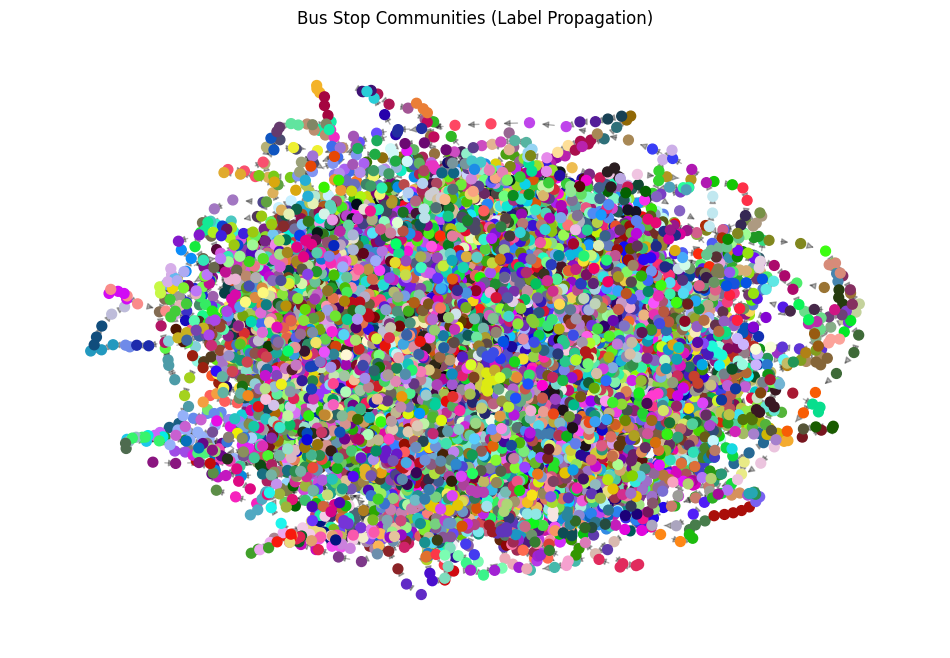

In [11]:
# Community detection using Label Propagation
lp_communities = nx.community.label_propagation_communities(DG.to_undirected())
lp_communities = list(lp_communities)

# Assign colors to label propagation communities
lp_color_map = {i: f"#{random.randint(0, 0xFFFFFF):06x}" for i in range(len(lp_communities))}
lp_node_colors = [None] * DG.number_of_nodes()
node_list = list(DG.nodes())
for idx, community in enumerate(lp_communities):
    for node in community:
        lp_node_colors[node_list.index(node)] = lp_color_map[idx]

# Draw the graph (Label Propagation)
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(DG, seed=42)
nx.draw_networkx_nodes(DG, pos, node_color=lp_node_colors, node_size=50)
nx.draw_networkx_edges(DG, pos, alpha=0.3)
plt.title("Bus Stop Communities (Label Propagation)")
plt.axis('off')
plt.show()

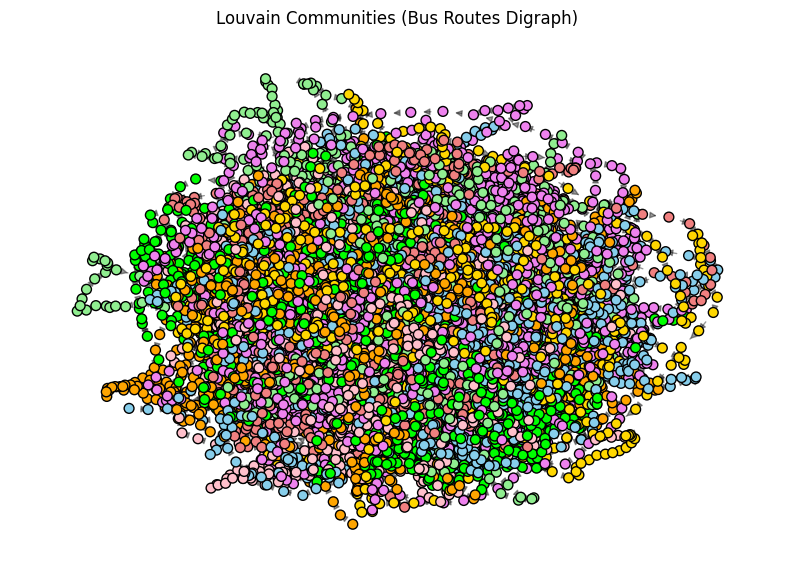

In [12]:
# Compute Louvain partition for the bus routes digraph
louvain_partition = nx.community.louvain_communities(DG.to_undirected())

# Assign a color to each community (fixed palette)
louvain_colors = ['skyblue', 'lightcoral', 'lightgreen', 'orange', 'violet', 'gold', 'lime', 'pink']
node_louvain_colors = ['gray'] * DG.number_of_nodes()
node_list = list(DG.nodes())
for idx, comm in enumerate(louvain_partition):
    for node in comm:
        node_louvain_colors[node_list.index(node)] = louvain_colors[idx % len(louvain_colors)]

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(DG, seed=42)
nx.draw_networkx_nodes(DG, pos, node_color=node_louvain_colors, node_size=50, edgecolors='black')
nx.draw_networkx_edges(DG, pos, alpha=0.4)
# Optionally, show labels for a small graph
# nx.draw_networkx_labels(DG, pos, font_size=8)
plt.title("Louvain Communities (Bus Routes Digraph)")
plt.axis('off')
plt.show()

In [13]:
# Export the final graph (with all node and edge attributes) to GEXF format
nx.write_gexf(DG, "../exports/london_bus_routes.gexf")
print("Graph exported to ../exports/london_bus_routes.gexf")

Graph exported to ../exports/london_bus_routes.gexf
